# Working with Model Level Met

Meteorology providers may choose to compute their data on different vertical levels. For example, the ECMWF IFS product is computed [on 137 model levels](https://confluence.ecmwf.int/display/UDOC/L137+model+level+definitions). The pressure of a given model level is not constant, but varies with time and horizontal position. The pressure at a given point can be computed [following ECMWF guidelines](https://confluence.ecmwf.int/display/CKB/ERA5%3A+compute+pressure+and+geopotential+on+model+levels%2C+geopotential+height+and+geometric+height).

All `pycontrails` models (e.g. `Cocip`, `ISSR`, `SAC`) require that the vertical coordinate of meteorological data is provided on pressure levels (hPa). This notebook converts model level data to pressure level data using the `ERA5ModelLevel` class. (Previously, the `metview` library was used for this purpose, but as of `pycontrails` v0.54.0 this re-interpolation onto pressure levels is done in-house.)

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from pycontrails import Fleet, Flight
from pycontrails.datalib.ecmwf import ERA5, ERA5ModelLevel
from pycontrails.models.cocip import Cocip
from pycontrails.models.humidity_scaling import HistogramMatching
from pycontrails.models.ps_model import PSFlight

## Target pressure levels

We must specify both model levels and target pressure levels. The model levels are the levels at which the meteorological data is provided. The target pressure levels are the levels at which we want to interpolate the data. The target pressure levels are chosen based on the altitudes at which contrails form.

Assuming a constant surface pressure of 1013.25 hPa, the table below shows that ECMWF model levels occur roughly every 10 hPa at altitudes for which contrails form. This informs how we set our target pressure levels: We define our target pressure levels ranging from 170 hPa to 390 hPa, spaced every 10 hPa. A finer spacing than this may be redundant (`pycontrails` models perform linear interpolation between pressure levels), and a coarser spacing would result in loss of information.

In [2]:
url = "https://confluence.ecmwf.int/display/UDOC/L137+model+level+definitions"
df = pd.read_html(url, na_values="-", index_col="n")[0].rename_axis("model_level")
df.loc[70:90]  # model levels 70 - 90 agree with our ERA5ModelLevel object below

,a [Pa],b,ph [hPa],pf [hPa],Geopotential Altitude [m],Geometric Altitude [m],Temperature [K],Density [kg/m^3]
model_level,,,,,,,,
70,15508.256836,0.011806,167.0450,163.0927,13077.79,13104.70,216.65,0.262244
71,16026.115234,0.014816,175.2731,171.1591,12771.64,12797.30,216.65,0.275215
72,16527.322266,0.018318,183.8344,179.5537,12467.99,12492.44,216.65,0.288713
73,17008.789063,0.022355,192.7389,188.2867,12166.81,12190.10,216.65,0.302755
74,17467.613281,0.026964,201.9969,197.3679,11868.08,11890.24,216.65,0.317357
75,17901.621094,0.032176,211.6186,206.8078,11571.79,11592.86,216.65,0.332536
76,18308.433594,0.038026,221.6146,216.6166,11277.92,11297.93,216.65,0.348308
77,18685.718750,0.044548,231.9954,226.8050,10986.70,11005.69,216.74,0.364545
78,19031.289063,0.051773,242.7719,237.3837,10696.22,10714.22,218.62,0.378253


## Make the CDS model level request



In [3]:
time = ("2024-01-15T00", "2024-01-15T18")

era5ml = ERA5ModelLevel(
    time=time,
    variables=("t", "q", "u", "v", "w", "ciwc"),
    grid=1,  # horizontal resolution, 0.25 by default
    model_levels=range(70, 91),
    pressure_levels=np.arange(170, 400, 10),
)
met = era5ml.open_metdataset()


era5sl = ERA5(
    time=time,
    variables=("tsr", "ttr"),
    grid=1,
    pressure_levels=-1,
)
rad = era5sl.open_metdataset()

## Missing values

Converting from model levels to pressure levels may result in some missing values. These are plotted below.

Points at which the surface pressure is significantly lower than the 1013.25 hPa reference surface pressure will result in missing values at the lowest-altitude target pressure levels. Additional model levels can be downloaded to decrease the number of missing values. Missing values do not occur at higher-altitude target pressure levels.

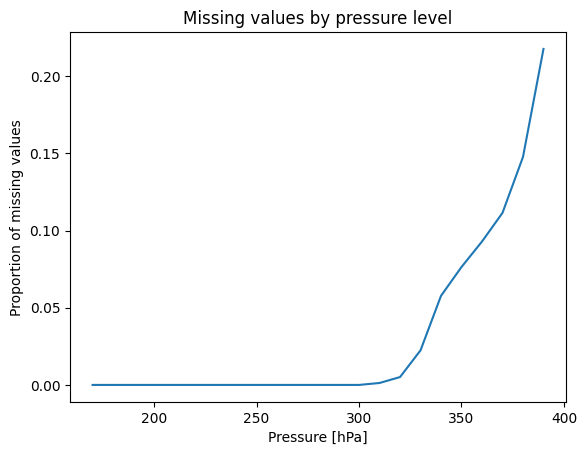

In [4]:
da = met.data["air_temperature"]
da.isnull().groupby("level").mean(...).plot()
plt.ylabel("Proportion of missing values")
plt.title("Missing values by pressure level");

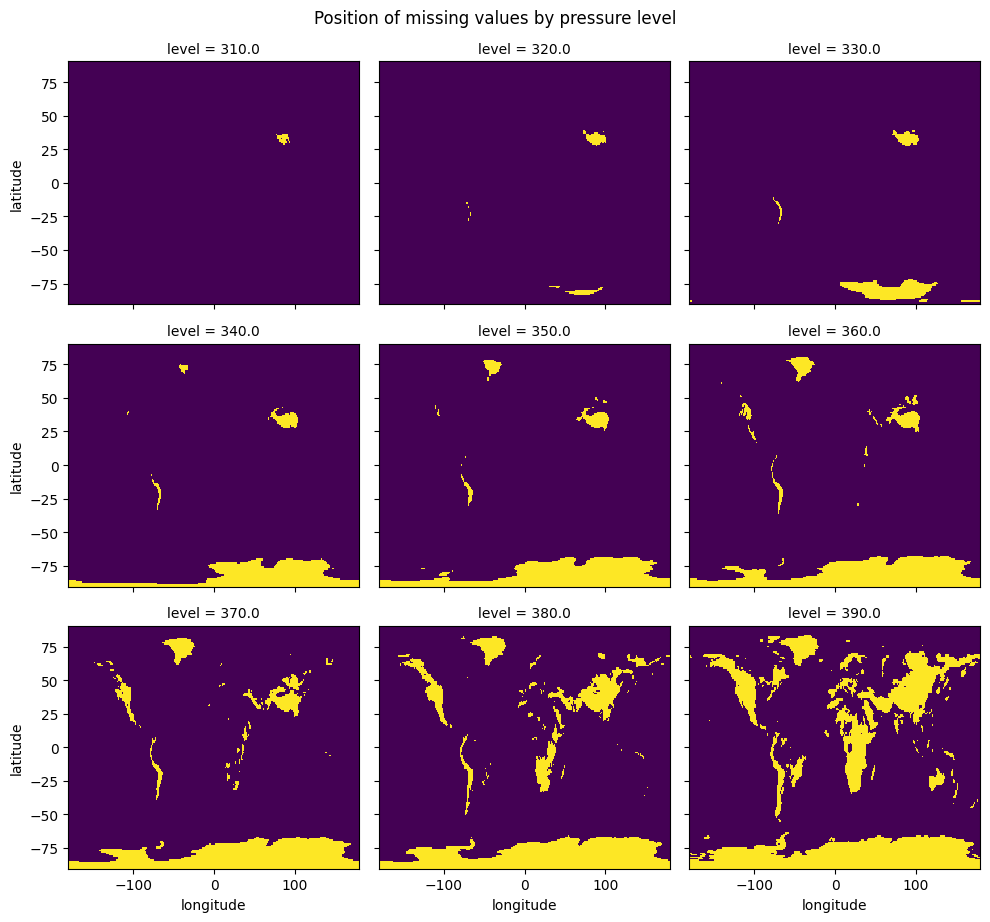

In [5]:
# There are no missing values above 310 hPa
tmp = da.isnull().isel(time=0).sel(level=slice(310, None))
tmp.plot(x="longitude", y="latitude", add_colorbar=False, col="level", col_wrap=3)
plt.gcf().suptitle("Position of missing values by pressure level", y=1.02);

## Download ADS-B

For flight trajectories, we use a sample from [Contrails API](https://api.contrails.org). We artificially shift the times of the flight trajectories to overlap the times of the ERA5 data.

In [6]:
df = pd.read_csv("https://apidocs.contrails.org/_static/fleet_sample.csv", parse_dates=["time"])
df["time"] = df["time"].dt.tz_convert(None)
df = df.rename(columns={"altitude": "altitude_ft"})

# Artificially shift time to the date of interest
df["time"] = df["time"] + (pd.Timestamp("2024-01-15") - df["time"].min())

# Convert to a pycontrails Fleet instance, keeping only aircraft type covered by the PS model
ps_flight = PSFlight()
flights = []
for flight_id, group in df.groupby("flight_id"):
    aircraft_type = group["aircraft_type"].iloc[0]
    if not ps_flight.check_aircraft_type_availability(aircraft_type, raise_error=False):
        continue

    engine_uid = group["engine_uid"].iloc[0]
    group = group.drop(columns=["aircraft_type", "engine_uid", "flight_id"])
    flight = Flight(group, aircraft_type=aircraft_type, engine_uid=engine_uid, flight_id=flight_id)
    flights.append(flight)

fleet = Fleet.from_seq(flights)

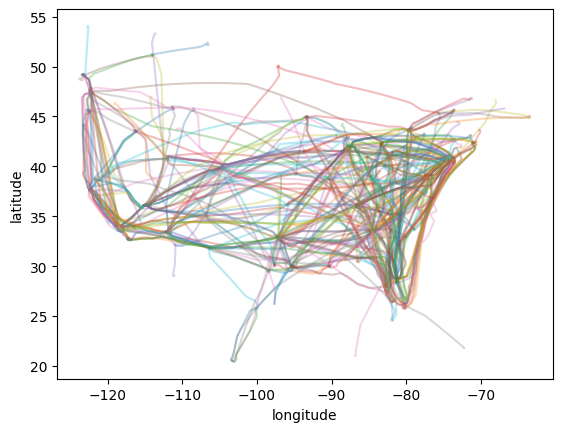

In [7]:
ax = plt.subplot()
for flight in flights:
    flight.plot(ax=ax, alpha=0.3)

## Run CoCiP

We run CoCiP on the model-level ERA5 data.

In [8]:
cocip = Cocip(
    met=met,
    rad=rad,
    dt_integration="5 min",
    max_age="12 hours",
    aircraft_performance=PSFlight(),
    humidity_scaling=HistogramMatching(),
)
cocip_pred = cocip.eval(fleet)
contrail = cocip.contrail

## Visualize output

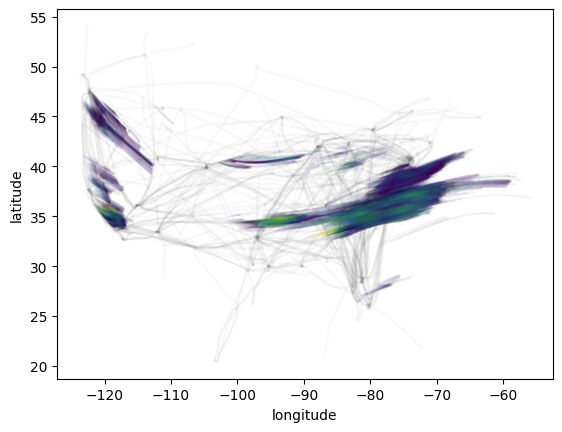

In [9]:
ax = plt.subplot()
for flight in flights:
    flight.plot(ax=ax, color="gray", alpha=0.05)

contrail.plot.scatter(
    x="longitude",
    y="latitude",
    s=contrail["width"] / 100000,
    c=contrail["tau_contrail"],
    vmin=0,
    vmax=0.3,
    alpha=0.05,
    zorder=2,
    ax=ax,
);